In [1]:
from pyspark.sql import SparkSession

In [2]:
MAX_MEMORY = '6g'
spark = SparkSession.builder.appName("taxi-analysis")\
            .config("spark.executor.memory", MAX_MEMORY)\
            .config("spark.driver.memory", MAX_MEMORY)\
            .getOrCreate()

In [3]:
spark

In [4]:
trips_file = "/Users/devkhk/Documents/data-engineering-study/data/trips/*"
zone_file = "/Users/devkhk/Documents/data-engineering-study/data/taxi+_zone_lookup.csv"

In [5]:
trip_data = spark.read.csv(f"file:///{trips_file}", inferSchema=True, header=True)
zone_data = spark.read.csv(f"file:///{zone_file}", inferSchema=True, header=True)

In [6]:
trip_data.show(5), zone_data.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       2| 2021-03-01 00:22:02|  2021-03-01 00:23:22|              1|          0.0|         1|                 N|         264|         264|           2|        3.0|  0.5|    0.5|       0.0|         0.0|                  0.3

(None, None)

In [7]:
trip_data.createOrReplaceTempView("trip")
zone_data.createOrReplaceTempView("zone")

In [8]:
trip_data.printSchema(), zone_data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



(None, None)

In [9]:
query = """
SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time, 
    HOUR(t.tpep_dropoff_datetime) as dropoff_tme,
    t.tpep_pickup_datetime as pickup_datetime,
    t.passenger_count,
    t.trip_distance,
    t.payment_type,
    t.fare_amount,
    t.tolls_amount,
    t.total_amount,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM
    trip t
LEFT JOIN
    zone pz
ON
    t.PULocationID = pz.LocationID
LEFT JOIN
    zone dz
ON
    t.DOLocationID = dz.LocationID
"""

comb_df = spark.sql(query)
comb_df.show(5), comb_df.printSchema()

+---------+-----------+------------+-----------+-----------+-------------------+---------------+-------------+------------+-----------+------------+------------+-----------------+--------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_tme|    pickup_datetime|passenger_count|trip_distance|payment_type|fare_amount|tolls_amount|total_amount|      pickup_zone|  dropoff_zone|
+---------+-----------+------------+-----------+-----------+-------------------+---------------+-------------+------------+-----------+------------+------------+-----------------+--------------+
|        2| 2021-03-01|  2021-03-01|          0|          0|2021-03-01 00:22:02|              1|          0.0|           2|        3.0|         0.0|         4.3|               NV|            NV|
|        2| 2021-03-01|  2021-03-01|          0|          0|2021-03-01 00:24:48|              1|          0.0|           2|        2.5|         0.0|         3.8|   Manhattanville|Manhattanville|
|        2| 2021-03-01|  

(None, None)

In [10]:
comb_df.createOrReplaceTempView("comb")

In [11]:
spark.sql("select pickup_zone, pickup_date, pickup_time from comb").show()

+--------------------+-----------+-----------+
|         pickup_zone|pickup_date|pickup_time|
+--------------------+-----------+-----------+
|                  NV| 2021-03-01|          0|
|      Manhattanville| 2021-03-01|          0|
|      Manhattanville| 2021-03-01|          0|
|   LaGuardia Airport| 2021-03-01|          0|
|        East Chelsea| 2021-03-01|          0|
|Upper West Side S...| 2021-03-01|          0|
|Penn Station/Madi...| 2021-03-01|          0|
|         JFK Airport| 2021-03-01|          0|
|   LaGuardia Airport| 2021-03-01|          0|
|   LaGuardia Airport| 2021-03-01|          0|
|         JFK Airport| 2021-03-01|          0|
|     Lenox Hill East| 2021-03-01|          0|
|Upper West Side S...| 2021-03-01|          0|
|    Hamilton Heights| 2021-03-01|          0|
|   East Harlem North| 2021-03-01|          0|
|Upper West Side S...| 2021-03-01|          0|
|         JFK Airport| 2021-03-01|          0|
|Upper West Side S...| 2021-03-01|          0|
|         JFK

In [12]:
spark.sql("select pickup_date, count(pickup_date) from comb group by pickup_date order by pickup_date").show()

+-----------+------------------+
|pickup_date|count(pickup_date)|
+-----------+------------------+
| 2002-12-31|                 1|
| 2003-01-05|                 1|
| 2004-04-04|                 1|
| 2008-12-31|                26|
| 2009-01-01|               111|
| 2020-12-31|                16|
| 2021-01-01|             24827|
| 2021-01-02|             34309|
| 2021-01-03|             26345|
| 2021-01-04|             44545|
| 2021-01-05|             46876|
| 2021-01-06|             49547|
| 2021-01-07|             50290|
| 2021-01-08|             50477|
| 2021-01-09|             39911|
| 2021-01-10|             29855|
| 2021-01-11|             46849|
| 2021-01-12|             50133|
| 2021-01-13|             51306|
| 2021-01-14|             53051|
+-----------+------------------+
only showing top 20 rows



In [13]:
comb_df.select("total_amount").describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



In [14]:
comb_df.select(["total_amount","trip_distance","passenger_count"]).describe().show()

+-------+-----------------+-----------------+------------------+
|summary|     total_amount|    trip_distance|   passenger_count|
+-------+-----------------+-----------------+------------------+
|  count|         15000700|         15000700|          14166672|
|   mean|18.75545205708744|6.628629402627818|1.4253783104458126|
| stddev|145.7442452805979|671.7293482115828|  1.04432704905968|
|    min|           -647.8|              0.0|                 0|
|    max|         398469.2|        332541.19|                 9|
+-------+-----------------+-----------------+------------------+



In [15]:
query = """
SELECT
    DATE_TRUNC("MM", pickup_date) as month,
    count(*) as trips
FROM
    comb
GROUP BY
    month
ORDER BY
    month
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2002-12-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2004-04-01 00:00:00|      1|
|2008-12-01 00:00:00|     26|
|2009-01-01 00:00:00|    111|
|2020-12-01 00:00:00|     16|
|2021-01-01 00:00:00|1369749|
|2021-02-01 00:00:00|1371688|
|2021-03-01 00:00:00|1925130|
|2021-04-01 00:00:00|2171215|
|2021-05-01 00:00:00|2507075|
|2021-06-01 00:00:00|2834204|
|2021-07-01 00:00:00|2821430|
|2021-08-01 00:00:00|     36|
|2021-09-01 00:00:00|      3|
|2021-10-01 00:00:00|      3|
|2021-11-01 00:00:00|      5|
|2021-12-01 00:00:00|      5|
|2029-05-01 00:00:00|      1|
+-------------------+-------+



In [16]:
query = """
SELECT
    *
FROM
    comb
WHERE
    pickup_date >= "2021-01-01" and
    pickup_date < "2021-08-01" and
    total_amount > 0 and
    total_amount < 5000 and
    trip_distance > 0 and
    trip_distance < 100 and
    passenger_count > 0 and
    passenger_count <= 4
"""
cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView('cleaned')

In [17]:
cleaned_df.show(3)

+---------+-----------+------------+-----------+-----------+-------------------+---------------+-------------+------------+-----------+------------+------------+--------------------+--------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_tme|    pickup_datetime|passenger_count|trip_distance|payment_type|fare_amount|tolls_amount|total_amount|         pickup_zone|  dropoff_zone|
+---------+-----------+------------+-----------+-----------+-------------------+---------------+-------------+------------+-----------+------------+------------+--------------------+--------------+
|        2| 2021-03-01|  2021-03-01|          0|          0|2021-03-01 00:02:13|              1|         1.13|           1|        5.5|         0.0|       11.16|        East Chelsea|            NV|
|        2| 2021-03-01|  2021-03-01|          0|          0|2021-03-01 00:40:16|              1|         2.68|           1|       10.5|         0.0|       18.59|Upper West Side S...|Yorkville East|
|        1

In [18]:
cleaned_df.select(["total_amount","trip_distance","passenger_count"]).describe().show()

+-------+------------------+------------------+------------------+
|summary|      total_amount|     trip_distance|   passenger_count|
+-------+------------------+------------------+------------------+
|  count|          13019207|          13019207|          13019207|
|   mean|18.003883030846975|2.8856136583433587|1.2827613847755859|
| stddev|12.965494908370037|3.6501932033364577|0.6135808273361556|
|    min|              0.01|              0.01|                 1|
|    max|            4973.3|             99.96|                 4|
+-------+------------------+------------------+------------------+



In [19]:
# visualization

import numpy as np
import pandas as pd
import seaborn as sns

In [75]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [76]:
# %matplotlib inline => 주피터 노트북에서 그래프 안보이면 추가하기
%matplotlib inline

In [21]:
query = """
SELECT
    pickup_date,
    count(pickup_date) as trips
FROM
    cleaned
GROUP BY
    pickup_date
ORDER BY
    pickup_date
"""
spark.sql(query).show()

+-----------+-----+
|pickup_date|trips|
+-----------+-----+
| 2021-01-01|20760|
| 2021-01-02|29706|
| 2021-01-03|22487|
| 2021-01-04|37422|
| 2021-01-05|39365|
| 2021-01-06|41928|
| 2021-01-07|42209|
| 2021-01-08|42457|
| 2021-01-09|34219|
| 2021-01-10|25627|
| 2021-01-11|39178|
| 2021-01-12|42148|
| 2021-01-13|43161|
| 2021-01-14|44640|
| 2021-01-15|44520|
| 2021-01-16|33296|
| 2021-01-17|27692|
| 2021-01-18|31934|
| 2021-01-19|43151|
| 2021-01-20|42119|
+-----------+-----+
only showing top 20 rows



In [22]:
pickupdate_df = spark.sql(query).toPandas()

In [23]:
pickupdate_df

,pickup_date,trips
0,2021-01-01,20760
1,2021-01-02,29706
2,2021-01-03,22487
3,2021-01-04,37422
4,2021-01-05,39365
...,...,...
207,2021-07-27,87024
208,2021-07-28,87329
209,2021-07-29,86874
210,2021-07-30,86664


<AxesSubplot:xlabel='pickup_date', ylabel='trips'>

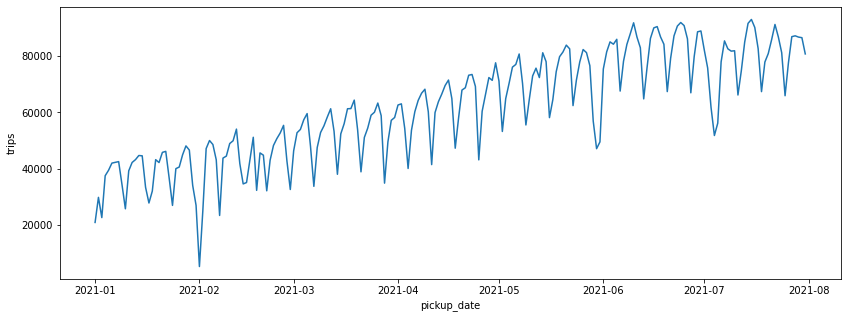

In [77]:
fig, ax = plt.subplots(figsize=(14,5))
sns.lineplot(data=pickupdate_df, x="pickup_date", y="trips")

In [25]:
cleaned_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_tme: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [56]:
query = """
SELECT
    DATE_FORMAT(pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned
GROUP BY
    pickup_date,
    day_of_week
"""
weeks_trip_df = spark.sql(query).toPandas()

In [57]:
weeks_trip_df

,day_of_week,trips
0,Wednesday,59007
1,Wednesday,53931
2,Friday,59588
3,Tuesday,52851
4,Friday,63347
...,...,...
207,Tuesday,57191
208,Saturday,69268
209,Sunday,34774
210,Sunday,43081


In [58]:
data = weeks_trip_df.groupby("day_of_week").trips.median().to_frame().reset_index()
data

,day_of_week,trips
0,Friday,71551.0
1,Monday,54908.0
2,Saturday,60233.0
3,Sunday,42236.0
4,Thursday,70524.5
5,Tuesday,65069.5
6,Wednesday,67674.0


In [62]:
data["sorted_dow"] = data["day_of_week"].replace({
    "Sunday" : 0,
    "Monday" : 1,
    "Tuesday" : 2,
    "Wednesday" : 3,
    "Thursday" : 4,
    "Friday" : 5,
    "Saturday" : 6,
})

In [69]:
data.sort_values(by="sorted_dow", inplace=True) # inplace : 데이터 변환 True, False : 보여주기만

In [70]:
data

,day_of_week,trips,sorted_dow
3,Sunday,42236.0,0
1,Monday,54908.0,1
5,Tuesday,65069.5,2
6,Wednesday,67674.0,3
4,Thursday,70524.5,4
0,Friday,71551.0,5
2,Saturday,60233.0,6


<AxesSubplot:xlabel='day_of_week', ylabel='trips'>

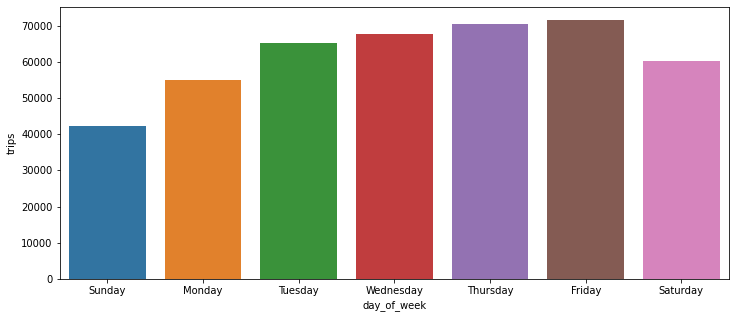

In [78]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=data, x="day_of_week", y="trips")